In [1]:
import numpy as np
import pandas as pd
from glob import glob
from scipy.stats import ranksums
from sklearn.metrics import roc_auc_score
from statsmodels.sandbox.stats.multicomp import multipletests as FDR
import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use("default")
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "Helvetica"



In [2]:
group_name = 'MOp'

In [3]:
region = group_name

In [4]:
tarall = [
    "PFC",
    "MOp",
    "SSp",
    "ACA",
    "AI",
    "AUDp",
    "RSP",
    "PTLp",
    "VISp",
    "MOB",
    "ENT",
    "HPF",
    "PIR",
    "AMY",
    "STR",
    "PAL",
    "TH",
    "HY",
    "SC",
    "VTA",
    "P",
    "MY",
    "CBN",
    "CBX",
]
print(len(tarall))


24


In [5]:
targroup = {
    "IT": ["PFC", "MOp", "SSp", "ACA", "AI", "AUDp", "RSP", "PTLp", "VISp", "ENT", "HPF", "PIR", "MOB", "AMY", "STR", "PAL"],
    "ET": ["TH", "HY", "SC", "VTA", "P", "MY"],
    "CB": ["CBN", "CBX"]
}
tarmap = {yy: xx for xx in targroup for yy in targroup[xx]}


In [6]:
adata = anndata.read_h5ad(f'/home/jzhou_salk_edu/sky_workdir/230129_targetpair_roc/data/{region}_RS2_geneCH.h5ad')
adata


AnnData object with n_obs × n_vars = 2568 × 9906
    obs: 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'FinalmCReads', 'Plate', 'PlateNormCov', 'Sample', 'SubRegion', 'DissectionRegion', 'Target', 'Sex', 'L1', 'L2', 'L3', 'L4', 'L1_annot', 'PassTargetFilter'
    var: 'chrom', 'end', 'start'
    obsm: 'X_pca'

In [9]:
adata.obs['TargetGroup'] = adata.obs['Target'].map(tarmap)
adata = adata[adata.obs['TargetGroup'].isin(['IT', 'ET'])].copy()
adata.obs['TargetGroup'].astype(str).value_counts()


IT    1409
ET    1159
Name: TargetGroup, dtype: int64

In [10]:
label = (adata.obs['TargetGroup']=='IT')


In [15]:
if (0<label.sum()<adata.shape[0]):
    datait = adata.X[label]
    dataet = adata.X[~label]
    fc = np.log2((datait.mean(axis=0) + 0.001) / (dataet.mean(axis=0) + 0.001))
    pv = [ranksums(xx, yy)[1] for xx,yy in zip(datait.T, dataet.T)]
    fdr = FDR(pv, 0.01, 'fdr_bh')[1]
    roc = [roc_auc_score(label, -xx) for xx in adata.X.T]
    result = pd.DataFrame([fc, fdr, roc], index=['log2FC', 'FDR', 'AUROC'], columns=adata.var.index).T
    result.to_hdf(f'/home/jzhou_salk_edu/sky_workdir/230203_ITvsET/result/{region}-diffgene.hdf', key='data')
    

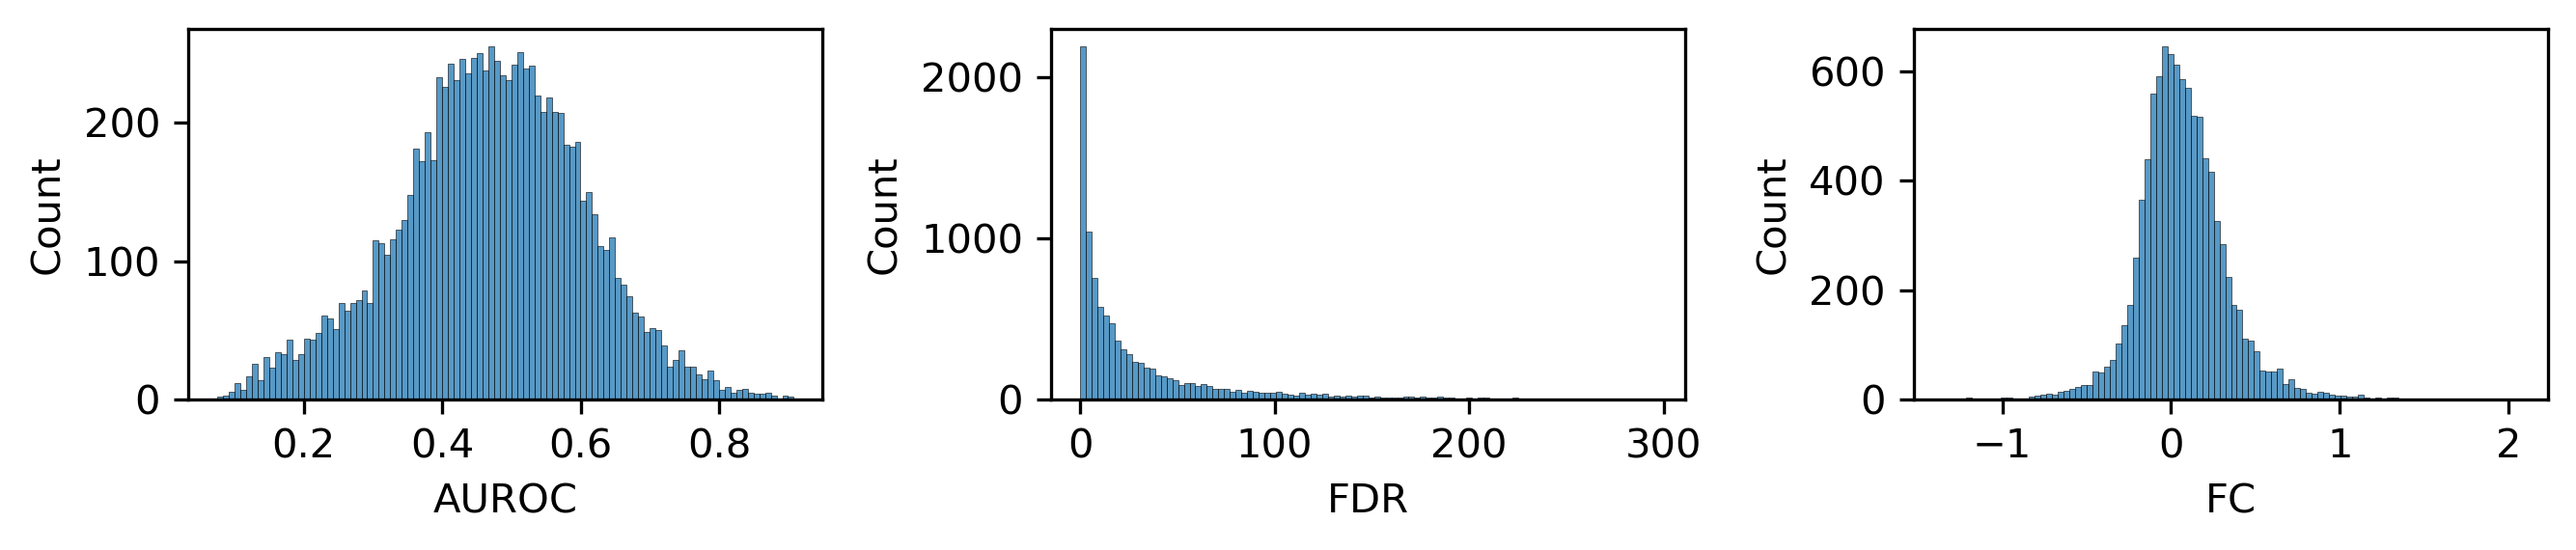

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2), dpi=300)
sns.histplot(result['AUROC'], bins=100, ax=axes[0])
sns.histplot(-np.log10(result['FDR']), bins=100, ax=axes[1])
sns.histplot(result['log2FC'], bins=100, ax=axes[2])
plt.tight_layout()
